### DEMAPP02 
# Approximating functions on $R^2$

This notebook illustrates how to use CompEcon Toolbox routines to construct and operate with an approximant for a function defined on a rectangle in $R^2$.

In particular, we construct an approximant for $f(x_1,x_2) = \frac{\cos(x_1)}{\exp(x_2)}$ on $[-1,1]\times[-1,1]$.  The function used in this illustration posseses a closed-form, which will allow us to measure approximation error precisely. Of course, in practical applications, the function to be approximated will not possess a known closed-form.

In order to carry out the exercise, one must first code the function to be approximated at arbitrary points.
Let's begin:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, BasisSpline, nodeunif, demo
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

### Preliminary tasks

Function to be approximated and analytic partial derivatives

In [2]:
exp, cos, sin = np.exp, np.cos, np.sin

f   = lambda x:  cos(x[0]) / exp(x[1])
d1  = lambda x: -sin(x[0]) / exp(x[1])
d2  = lambda x: -cos(x[0]) / exp(x[1])
d11 = lambda x: -cos(x[0]) / exp(x[1])
d12 = lambda x:  sin(x[0]) / exp(x[1])
d22 = lambda x:  cos(x[0]) / exp(x[1])

Set the points of approximation interval:

In [3]:
a, b = 0, 1

Choose an approximation scheme. In this case, let us use an 6 by 6 Chebychev approximation scheme:

In [4]:
n = 6  # order of approximation
basis = BasisChebyshev([n, n], a, b)  
# write n twice to indicate the two dimensions. 
# a and b are broadcast.

### Compute the basis coefficients c.  

There are various way to do this:

* One may compute the standard approximation nodes `x` and corresponding interpolation matrix `Phi` and function values `y` and use:

In [5]:
x = basis.nodes
Phi = basis.Phi(x)  # input x may be omitted if evaluating at the basis nodes
y = f(x)
c = np.linalg.solve(Phi, y)

* Alternatively, one may compute the standard approximation nodes `x` and corresponding function values `y` and use these values to create a `BasisChebyshev` object with keyword argument `y`:

In [6]:
x = basis.nodes
y = f(x)
fa = BasisChebyshev([n, n], a, b, y=y)
# coefficients can be retrieved by typing fa.c

* ... or one may simply pass the function directly to BasisChebyshev using keyword `f`, which by default will evaluate it at the basis nodes

In [7]:
F = BasisChebyshev([n, n], a, b, f=f)
# coefficients can be retrieved by typing F.c

### Evaluate the basis

Having created a `BasisChebyshev` object, one may now evaluate the approximant at any point `x` by calling the object:

In [8]:
x = np.array([[0.5],[0.5]]) # first dimension should match the basis dimension
y = F(x)

... one may also evaluate the approximant's first partial derivatives at `x`:

In [9]:
dfit1 = F(x, [1, 0])
dfit2 = F(x, [0, 1])

... one may also evaluate the approximant's second own partial and cross partial derivatives at `x`:

In [10]:
dfit11 = F(x, [2, 0])
dfit22 = F(x, [0, 2])
dfit12 = F(x, [1, 1])

### Compare analytic and numerical computations

In [11]:
ff = '%-11s %12.5f  %12.5f'
print('Function Values and Derivatives of cos(x_1)/exp(x_2) at x=(0.5,0.5)')
print('%-11s %12s  %12s\n' % ('','Numerical', 'Analytic'), '_'*40)
print(ff % ('Function',F(x),f(x)))
print(ff % ('Partial 1',dfit1, d1(x)))
print(ff % ('Partial 2',dfit2, d2(x)))
print(ff % ('Partial 11',dfit11, d11(x)))
print(ff % ('Partial 12', dfit12, d12(x)))
print(ff % ('Partial 22',dfit22, d22(x)))

Function Values and Derivatives of cos(x_1)/exp(x_2) at x=(0.5,0.5)
               Numerical      Analytic
 ________________________________________
Function         0.53228       0.53228
Partial 1       -0.29079      -0.29079
Partial 2       -0.53228      -0.53228
Partial 11      -0.53223      -0.53228
Partial 12       0.29079       0.29079
Partial 22       0.53223       0.53228


The cell below shows how the preceeding table could be generated in a single loop, using the `zip` function and computing all partial derivatives at once.

In [12]:
labels = ['Function', 'Partial 1','Partial 2','Partial 11','Partial 12','Partial 22']
analytics =[func(x) for func in [f,d1,d2,d11,d12,d22]]
deriv = [[0, 1, 0, 2, 0, 1],
         [0, 0, 1, 0, 2, 1]]

ff = '%-11s %12.5f  %12.5f'
print('Function Values and Derivatives of cos(x_1)/exp(x_2) at x=(0.5,0.5)')
print('%-11s %12s  %12s\n' % ('','Numerical', 'Analytic'), '_'*40)
for lab,appr,an in zip(labels, F(x,order=deriv),analytics):
    print(f'{lab:11s} {an[0]:12.5f} {appr:12.5f}')


Function Values and Derivatives of cos(x_1)/exp(x_2) at x=(0.5,0.5)
               Numerical      Analytic
 ________________________________________
Function         0.53228      0.53228
Partial 1       -0.29079     -0.29079
Partial 2       -0.53228     -0.53228
Partial 11      -0.53228     -0.53223
Partial 12       0.29079      0.53223
Partial 22       0.53228      0.29079


### Approximation accuracy

One may evaluate the accuracy of the Chebychev polynomial approximant by computing the  approximation error on a highly refined grid of points:

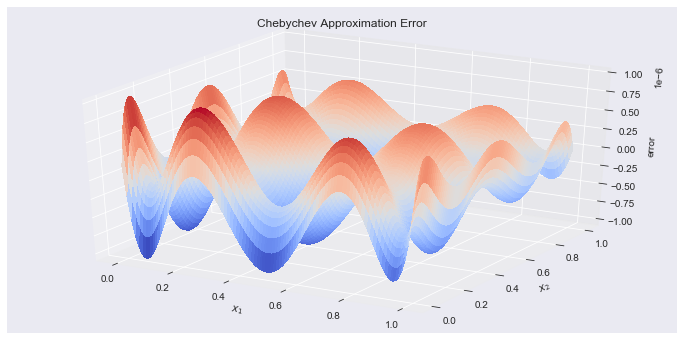

In [13]:
nplot = [101, 101]         # chose grid discretization
X = nodeunif(nplot, [a, a], [b, b])  # generate refined grid for plotting
yapp = F(X)        # approximant values at grid nodes
yact = f(X)                      # actual function values at grid points
error = (yapp - yact).reshape(nplot)
X1, X2 = X
X1.shape = nplot
X2.shape = nplot

fig1 = plt.figure(figsize=[12, 6])
ax = fig1.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X1, X2, error, rstride=1, cstride=1, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('error')
plt.title('Chebychev Approximation Error')
plt.ticklabel_format(style='sci', axis='z', scilimits=(-1,1))

The plot indicates that an order 11 by 11 Chebychev approximation scheme produces approximation errors no bigger in magnitude than $10^{-10}$.

Let us repeat the approximation exercise, this time constructing an order 21 by 21 cubic spline approximation scheme:

Text(0.5,0.92,'Cubic Spline Approximation Error')

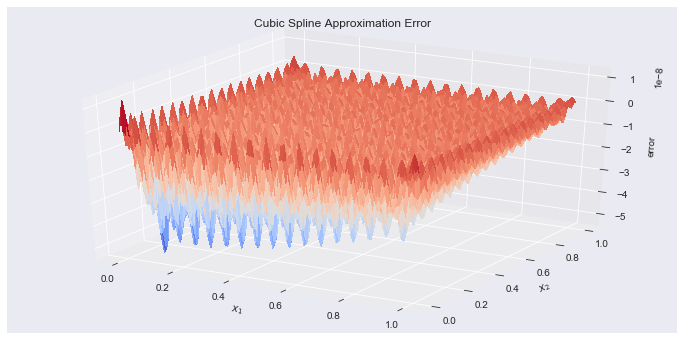

In [14]:
n = [21, 21]                          # order of approximation
S = BasisSpline(n, a, b, f=f)
yapp = S(X)        # approximant values at grid nodes
error = (yapp - yact).reshape(nplot)

fig2 = plt.figure(figsize=[12, 6])
ax = fig2.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X1, X2, error, rstride=1, cstride=1, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('error')
plt.title('Cubic Spline Approximation Error')

The plot indicates that an order 21 by 21 cubic spline approximation scheme produces approximation errors no bigger in magnitude than $10^{-6}$.

In [15]:
#demo.savefig([fig1,fig2])